In [12]:
import pickle
import numpy as np

with open('track_path.pkl', 'rb') as f:
    data = pickle.load(f)

# Examine the structure
print(type(data))
print(len(data))
print(data.keys())  # or use data.keys() if it's a dictionary

<class 'dict'>
411
dict_keys([1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 16, 18, 19, 21, 22, 24, 25, 27, 28, 29, 30, 31, 32, 33, 35, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 54, 55, 57, 60, 62, 63, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 108, 110, 111, 112, 113, 114, 115, 117, 118, 119, 121, 122, 124, 125, 126, 127, 129, 130, 131, 133, 134, 135, 136, 138, 139, 141, 142, 143, 144, 145, 146, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 175, 176, 177, 178, 179, 180, 181, 184, 187, 190, 191, 192, 193, 198, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236, 237, 238, 239, 241, 242, 243, 244, 245, 247, 248, 249, 250, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 263, 264

c:\Users\manan\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\manan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\manan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\manan\AppData\Local\Temp\ipykernel_19256\2514939831.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two m

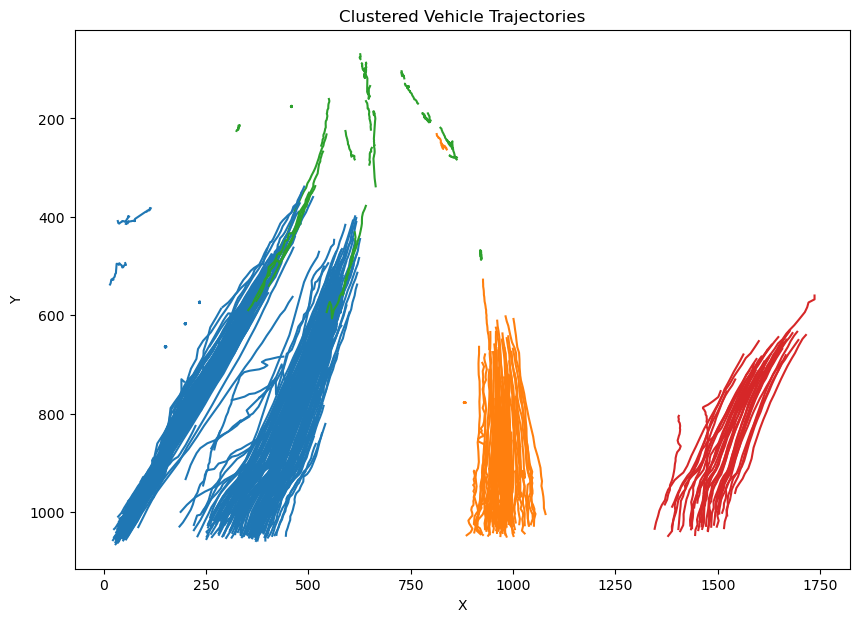

In [14]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist

# Load the pickled trajectory data
with open("track_path.pkl", "rb") as f:
    track_history = pickle.load(f)

trajectories = list(track_history.values())
trajectories = [traj for traj in trajectories if len(traj) > 5]  # Filter short ones

# Resample trajectories to same length for distance calculation
def resample(traj, num_points=20):
    traj = np.array(traj)
    idx = np.linspace(0, len(traj)-1, num_points).astype(int)
    return traj[idx]

resampled = [resample(traj) for traj in trajectories]

# Compute pairwise DTW distances
def dtw_distance_matrix(trajs):
    n = len(trajs)
    dists = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist, _ = fastdtw(trajs[i], trajs[j])
            dists[i, j] = dists[j, i] = dist
    return dists

dist_matrix = dtw_distance_matrix(resampled)

# Apply KMeans with precomputed distances using MDS projection
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
X_mds = mds.fit_transform(dist_matrix)

kmeans = KMeans(n_clusters=4, random_state=42).fit(X_mds)
labels = kmeans.labels_

# Plot clustered trajectories
plt.figure(figsize=(10, 7))
colors = plt.cm.get_cmap("tab10", 10)

for i, traj in enumerate(trajectories):
    traj = np.array(traj)
    plt.plot(traj[:, 0], traj[:, 1], color=colors(labels[i]))

plt.gca().invert_yaxis()
plt.title("Clustered Vehicle Trajectories")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

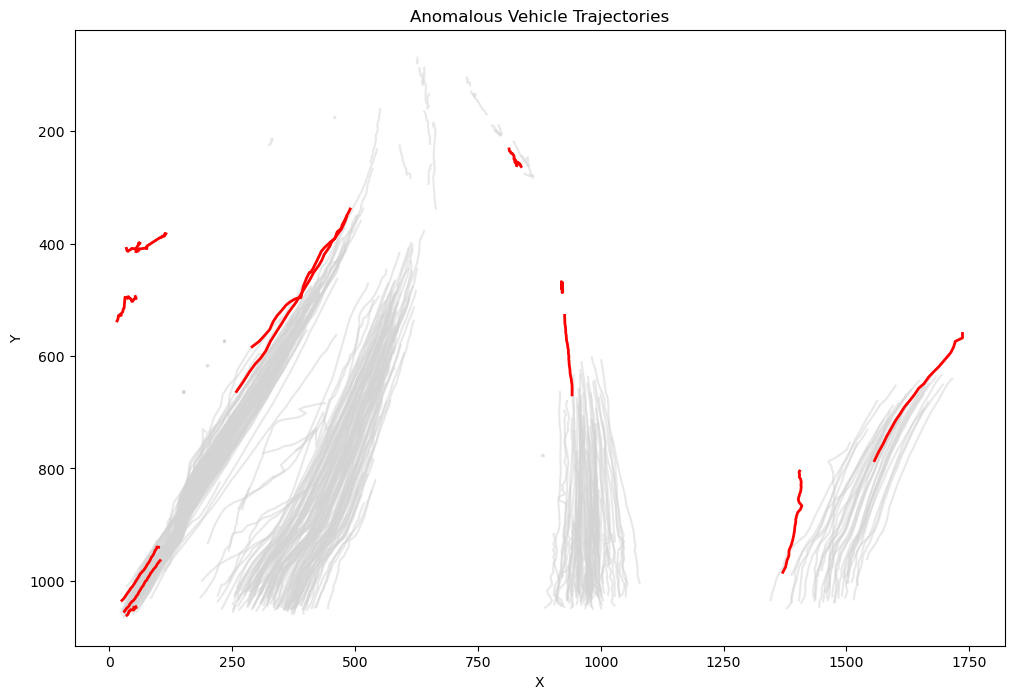

In [17]:
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

# Group trajectories by cluster
clustered_trajectories = [[] for _ in range(4)] # Assuming 4 clusters
for traj, label in zip(trajectories, labels):
    clustered_trajectories[label].append(traj)

# Compute cluster centroids (medoid - trajectory with minimal total DTW to others)
centroids = []
for cluster_trajs in clustered_trajectories:
    min_total_dtw = float('inf')
    medoid = None
    for i, t1 in enumerate(cluster_trajs):
        total_dtw = sum(fastdtw(t1, t2, dist=euclidean)[0] for t2 in cluster_trajs)
        if total_dtw < min_total_dtw:
            min_total_dtw = total_dtw
            medoid = t1
    centroids.append(medoid)

# Anomaly detection: flag if DTW to centroid > mean + 2 * std
anomalies = []
for cluster_idx, cluster_trajs in enumerate(clustered_trajectories):
    dists = [fastdtw(traj, centroids[cluster_idx], dist=euclidean)[0] for traj in cluster_trajs]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    threshold = mean_dist + 2 * std_dist
    for traj, dist in zip(cluster_trajs, dists):
        if dist > threshold:
            anomalies.append(traj)

# Plot anomalies
plt.figure(figsize=(12, 8))
for traj in trajectories:
    plt.plot(*zip(*traj), color='lightgray', alpha=0.5)  # All
for traj in anomalies:
    plt.plot(*zip(*traj), color='red', linewidth=2)      # Anomalies
plt.title("Anomalous Vehicle Trajectories")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().invert_yaxis()
plt.show()
